# Fastai example

> Showing how to use fastai with a simple example.

In [ ]:
import pandas as pd
from pathlib import Path
import fastcore.all as fc

from fastai.data.all import *
from fastai.vision.all import *

import warnings
warnings.filterwarnings('ignore')

In [ ]:
ossl_source = '../../_data/ossl-tfm/ossl-tfm.csv'
df = pd.read_csv(ossl_source); df.head()

,fname,kex
0,3998362dd2659e2252cd7f38b43c9b1f.png,0.182895
1,2bab4dbbac073b8648475ad50d40eb95.png,0.082741
2,29213d2193232be8867d85dec463ec00.png,0.089915
3,8b1ee9146c026faee20a40df86736864.png,0.135030
4,6e8e9d1105e7da7055555cb5d310df5f.png,0.270421


In [ ]:
df['kex'].min(), df['kex'].max() 

(0.0, 3.6521352871126975)

In [ ]:
df.shape

(57674, 2)

In [ ]:
# image size is 750x281

In [ ]:
# ossl_source = '../../_data/ossl-tfm/ossl-tfm.csv'
# df = pd.read_csv(ossl_source); df.head()

# ossl = DataBlock(blocks=(ImageBlock, RegressionBlock),
#                 get_x=ColReader(0, pref='../../_data/ossl-tfm/img/'),
#                 get_y=ColReader(1),
#                 batch_tfms=Normalize.from_stats(*imagenet_stats),
#                 item_tfms=RatioResize(224),
#                 splitter=RandomSplitter(valid_pct=0.1, seed=41)
                
# dls = ossl.dataloaders(df)

# learn = vision_learner(dls, resnet18, pretrained=False, metrics=R2Score())
# learn.fit_one_cycle(20, 2e-3)

In [ ]:
ossl = DataBlock(blocks=(ImageBlock, RegressionBlock),
                get_x=ColReader(0, pref='../../_data/ossl-tfm/img/'),
                get_y=ColReader(1),
                batch_tfms=Normalize.from_stats(*imagenet_stats),
                item_tfms=RatioResize(224),
                splitter=RandomSplitter(valid_pct=0.1, seed=41)
#    batch_tfms=aug_transforms()
)

In [ ]:
ossl.summary(df)

Setting-up type transforms pipelines
0      3998362dd2659e2252cd7f38b43c9b1f.png  0.182895
1      2bab4dbbac073b8648475ad50d40eb95.png  0.082741
2      29213d2193232be8867d85dec463ec00.png  0.089915
3      8b1ee9146c026faee20a40df86736864.png  0.135030
4      6e8e9d1105e7da7055555cb5d310df5f.png  0.270421
...                                     ...       ...
57669  8d1089ede5cae335779364ab6d97e0dd.png  0.366362
57670  3700237aa002dee08e991b451003b3d7.png  0.485567
57671  b790da349d49885c5727a2b5fd67b13d.png  1.243033
57672  a057a7ead9eebce24d4039de7fd5e01b.png  0.381496
57673  80bf4a0dc30f60552a38193d5c09b9cd.png  0.960841

[57674 rows x 2 columns]
Found 57674 items
2 datasets of sizes 51907,5767
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': '../../_data/ossl-tfm/img/', 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': None} -> RegressionSetup -- {'c': None}

Building one sample
  Pipeline: Co

In [ ]:
dls = ossl.dataloaders(df)

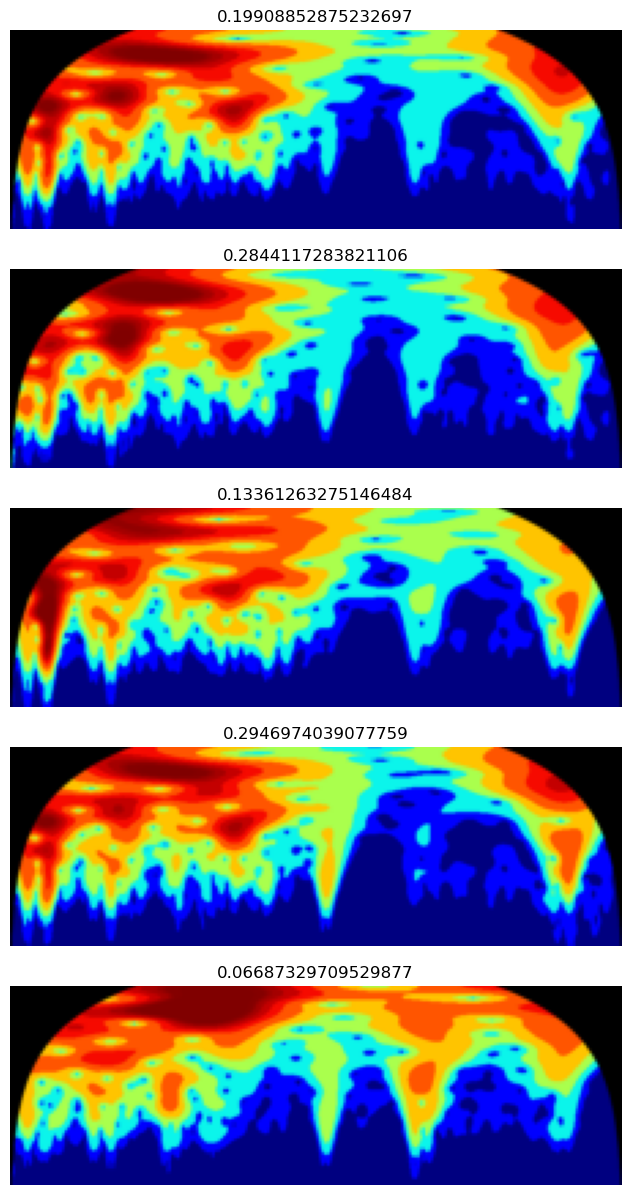

In [ ]:
dls.show_batch(nrows=5, ncols=1, figsize=(10, 15))

In [ ]:
learn = vision_learner(dls, resnet18, pretrained=False, metrics=R2Score())

SuggestedLRs(valley=0.00363078061491251)

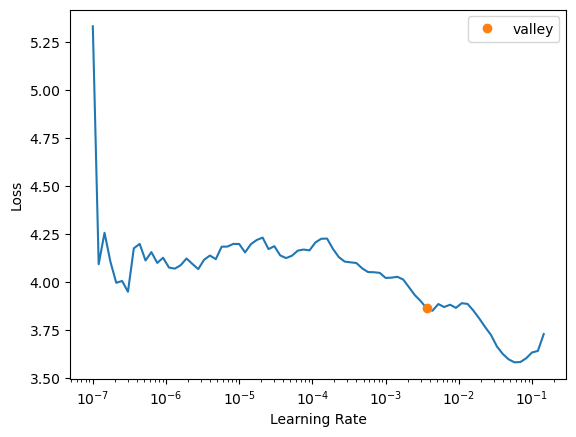

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 2e-3)

epoch,train_loss,valid_loss,r2_score,time
0,1.010429,0.160208,-0.149856,07:33
1,0.101805,0.105252,0.244579,07:37
2,0.080996,0.092230,0.338037,07:45
3,0.061543,0.068272,0.509990,07:48
4,0.061344,0.045711,0.671919,07:57
5,0.055588,0.044312,0.681960,08:00
6,0.047412,0.038732,0.722007,08:06
7,0.042374,0.045522,0.673274,08:08
8,0.037796,0.034118,0.755128,08:07
9,0.030448,0.033509,0.759500,08:13


## Evaluation

In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.valid)


In [ ]:
# Assuming you have a new CSV file for your test data
# test_source = '../../_data/ossl-tfm/ossl-tfm-test.csv'
# test_df = pd.read_csv(test_source)

# # Create a new DataLoader for the test data
# test_dl = learn.dls.test_dl(test_df)

# # Get predictions on the test set
# test_preds, test_targets = learn.get_preds(dl=test_dl)

# # Now you can use test_preds and test_targets for further analysis

In [ ]:
# Convert predictions and targets to numpy arrays
# val_preds = val_preds.numpy().flatten()
# val_targets = val_targets.numpy()

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Predicted': val_preds,
    'Actual': val_targets
})

# Display the first few rows of the results
print(results_df.head())

# Calculate and print the R2 score
from sklearn.metrics import r2_score
r2 = r2_score(val_targets, val_preds)
print(f"R2 Score on validation set: {r2:.4f}")

   Predicted    Actual
0   0.153120  0.000000
1   0.189220  0.184960
2   0.325809  0.194201
3   0.442900  0.262364
4   0.335543  0.355799
R2 Score on validation set: 0.8270


In [ ]:
val_preds_np = val_preds
val_targets_np = val_targets

# Apply the transformation: exp(y) - 1
val_preds_transformed = np.exp(val_preds_np) - 1
val_targets_transformed = np.exp(val_targets_np) - 1

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Predicted': val_preds_transformed,
    'Actual': val_targets_transformed
})

# Display the first few rows of the results
print(results_df.head())

# Calculate and print the R2 score
from sklearn.metrics import r2_score
r2 = r2_score(val_targets_transformed, val_preds_transformed)
print(f"R2 Score on validation set (after transformation): {r2:.4f}")

# Calculate and print the MAPE, handling zero values
def mean_absolute_percentage_error(y_true, y_pred):
    non_zero = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(val_targets_transformed, val_preds_transformed)
print(f"Mean Absolute Percentage Error (MAPE) on validation set: {mape:.2f}%")

# Calculate and print the MAE as an alternative metric
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_targets_transformed, val_preds_transformed)
print(f"Mean Absolute Error (MAE) on validation set: {mae:.4f}")

   Predicted   Actual
0   0.165464  0.00000
1   0.208306  0.20317
2   0.385151  0.21434
3   0.557217  0.30000
4   0.398699  0.42732
R2 Score on validation set (after transformation): 0.6978
Mean Absolute Percentage Error (MAPE) on validation set: 47.85%
Mean Absolute Error (MAE) on validation set: 0.1948


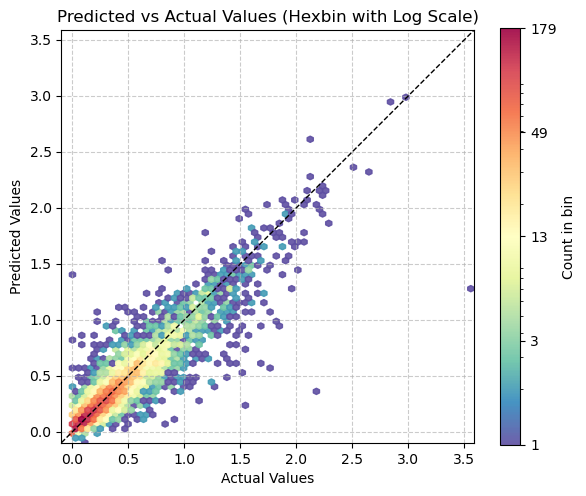

Min non-zero count in hexbins: 1.0
Max count in hexbins: 180.0


In [ ]:
plt.figure(figsize=(6, 6))

# Use logarithmic bins for the colormap
h = plt.hexbin(val_targets, val_preds, gridsize=65, 
               bins='log', cmap='Spectral_r', mincnt=1,
               alpha=0.9)

# Get the actual min and max counts from the hexbin data
counts = h.get_array()
min_count = counts[counts > 0].min()  # Minimum non-zero count
max_count = counts.max()

# Create a logarithmic colorbar
cb = plt.colorbar(h, label='Count in bin', shrink=0.73)
tick_locations = np.logspace(np.log10(min_count), np.log10(max_count), 5)
cb.set_ticks(tick_locations)
cb.set_ticklabels([f'{int(x)}' for x in tick_locations])

# Add the diagonal line
min_val = min(val_targets.min(), val_preds.min())
max_val = max(val_targets.max(), val_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

# Set labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Hexbin with Log Scale)')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.65)

# Set the same limits for both axes
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Make the plot square
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Print the range of counts in the hexbins
print(f"Min non-zero count in hexbins: {min_count}")
print(f"Max count in hexbins: {max_count}")

In [ ]:
path_model = Path('./models')
learn.export(path_model / '0.pkl')

## Inference

In [ ]:
ossl_source = Path('../../_data/ossl-tfm/img')
learn.predict(ossl_source / '0a0a0c647671fd3030cc13ba5432eb88.png')

((0.5229991674423218,), tensor([0.5230]), tensor([0.5230]))

In [ ]:
df[df['fname'] == '0a0a0c647671fd3030cc13ba5432eb88.png']

,fname,kex
28867,0a0a0c647671fd3030cc13ba5432eb88.png,0.525379


In [ ]:
np.exp(3) - 1

19.085536923187668

## Experiments:


Color scale: `viridis` | Discretization: `percentiles = [i for i in range(60, 100)]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | with axis ticks |
|-----------|------------|----------------|--------|----------|----------------|------------|----------------|
| ResNet-18 | 100        | 1e-3           | 10     | 0.648    | 05:12          | No        | Yes             |
| ResNet-18 | 224        | 2e-3           | 10     | 0.69     | 07:30          | No        | Yes             |
| ResNet-18 | 750 (original size)        |    1e-3        | 10     | 0.71          | 36:00          | No         | Yes             |
| ResNet-18 | 224        | 2e-3           | 20     |   0.704   | 07:30          | No        | Yes             |
| ResNet-18 | 224        | 2e-3           | 10     |   0.71   | 07:00          | No        | No             |
    

Discretization: `percentiles = [i for i in range(20, 100)]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | with axis ticks | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.7      | 05:12          | No         | No              | `viridis`    |
| ResNet-18 | 224        | 3e-3          | 10     | 0.71      | 05:12          | No         | No              | `jet`        |

From now on `with axis ticks` is always `No`.

Discretization: esimated on `10000` cwt power percentiles `[20, 30, 40, 50, 60, 70, 80, 90, 95, 97, 99]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | remark | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.71      | 05:12          | No         | None              | `jet`    |
| ResNet-18 | 224        | 2e-3         | 10     | 0.685      | 05:12          | No         | y range added              | `jet`    |


From now on random splitter with `10%` validation and random seed `41`.

Discretization: esimated on `10000` cwt power percentiles `[20, 30, 40, 50, 60, 70, 80, 90, 95, 97, 99]`

| Model     | Image Size | Learning Rate | Epochs | R2 Score | Time per Epoch | Finetuning | remark | colour scale |
|-----------|------------|---------------|--------|----------|----------------|------------|-----------------|--------------|
| ResNet-18 | 224        | 2e-3          | 10     | 0.7      | 05:12          | No         | Pre-train & normalize: True              | `jet`    |
| ResNet-18 | 224        | 2e-3          | 10     | 0.796     | 08:12          | No         | No Pre-train              | `jet`    |
| ResNet-18 | 224        | 3e-3          | 10     | 0.7     | 05:12          | No         | Pre-train & normalize: False            | `jet`    |
| ResNet-18 (id=0)| 224        | 2e-3          | 20     | **0.829**     | 08:12          | No         | No Pre-train (try 18 epochs)              | `jet`    |
